## Imports and settings

In [1]:
import src
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import keras.backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization, TimeDistributed, LSTM
from keras.optimizers import Adam, RMSprop
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14808019460498609607
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1508248780
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9931691252605696074
physical_device_desc: "device: 0, name: GeForce GT 740M, pci bus id: 0000:01:00.0, compute capability: 3.5"
]


In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #"" for CPU

Load dataset.

In [7]:
past = 2
name = f"unet_{past}-1"
batch_size=64
epochs = 30

In [5]:
train, xval, test = src.load_datasets(past_frames=past)

Training data: (7500, 64, 64, 3)
Validation data: (1500, 64, 64, 3)
Test data: (1000, 64, 64, 3)


In [6]:
unet_train, unet_truth, unet_val, unet_val_truth, unet_test, unet_test_truth = src.split_datasets(
            train[:2000], xval, test, past_frames=past, augment=True)

Data augmentation.
Shape of training data:  (8000, 64, 64, 2) 
Shape of training truth:  (8000, 64, 64, 1) 
Shape of validation data:  (1500, 64, 64, 2) 
Shape of validation truth:  (1500, 64, 64, 1) 
Shape of test data:  (1000, 64, 64, 2) 
Shape of test truth:  (1000, 64, 64, 1)


## U-net

In [38]:
model = src.unet(input_shape=(64, 64, past), dropout=0, batchnorm=True)

In [39]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 2)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 16)   528         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 32, 32, 16)   64          conv2d_6[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_10 (LeakyReLU)      (None, 32, 32, 16)   0           batch_normalization_10[0][0]     
__________________________________________________________________________________________________
conv2d_7 (

In [40]:
#train the model
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate = 0.0001),loss=src.custom_loss("l2+gdl"), metrics=[src.relative_error_tensor]) 

***Using L2 + gradient difference loss.***
Tensor("metrics_1/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("conv2d_transpose_10_target:0", shape=(?, ?, ?, ?), dtype=float32)


In [41]:
model.fit(unet_train,
          unet_truth,
          batch_size = batch_size,
          epochs=epochs,
          validation_data=(unet_val,unet_val_truth),
          shuffle = True)

Train on 8000 samples, validate on 1500 samples
Epoch 1/30
8000/8000 [==============================] - 22s 3ms/step - loss: 0.3744 - relative_error_tensor: 1.4261 - val_loss: 0.1558 - val_relative_error_tensor: 0.9142
Epoch 2/30
8000/8000 [==============================] - 21s 3ms/step - loss: 0.1854 - relative_error_tensor: 0.9106 - val_loss: 0.1349 - val_relative_error_tensor: 0.8081
Epoch 3/30
8000/8000 [==============================] - 32s 4ms/step - loss: 0.1394 - relative_error_tensor: 0.7762 - val_loss: 0.1261 - val_relative_error_tensor: 0.7659
Epoch 4/30
8000/8000 [==============================] - 36s 4ms/step - loss: 0.1188 - relative_error_tensor: 0.7241 - val_loss: 0.1152 - val_relative_error_tensor: 0.7186
Epoch 5/30
8000/8000 [==============================] - 36s 4ms/step - loss: 0.1076 - relative_error_tensor: 0.6954 - val_loss: 0.1062 - val_relative_error_tensor: 0.6898
Epoch 6/30
8000/8000 [==============================] - 41s 5ms/step - loss: 0.1009 - relative_er

## Save features

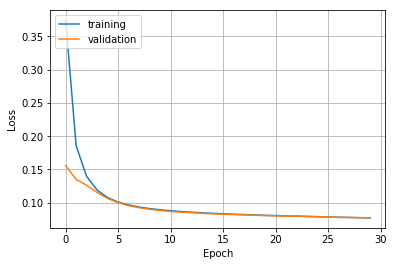

In [43]:
hist = model.history
hist.history.keys()
plt.plot(hist.history['loss'],)
plt.plot(hist.history['val_loss'])
plt.grid()
plt.legend(['training', 'validation'], loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.yscale("log")
plt.savefig(name+'_curves.png')

Predict future frames. Loads a 20 long sequence with 1000 sequence samples.

In [44]:
sequence_test = src.load_datasets(prediction=True)

Test data: (1000, 64, 64, 20)


In [45]:
sequence_test = src.augment_data(sequence_test[:100])

In [46]:
sequence_test.shape

(400, 64, 64, 20)

In [47]:
#test
predictions = {}
past_frames = sequence_test[...,0:past]
test_truth = sequence_test[...,past:past+1]

In [48]:
for t in range(5):
    future = model.predict(past_frames, batch_size=64)
    predictions[f"{t}"] = future
    past_frames = np.concatenate((past_frames[:,:,:,1:], predictions[f"{t}"]), axis=-1)
    test_truth = sequence_test[...,past+1+t:past+2+t]

Save example predictions

In [49]:
src.save_examples(name, sequence_test, predictions, past, samples=[33]) # 33, 46, 54

Calculate scores

In [50]:
#test
predictions = model.predict(unet_test, batch_size=50)
truth       = unet_test_truth
truth.shape

(1000, 64, 64, 1)

Get ordered predictions by pixelwise difference

In [51]:
args = src.arg_getter(truth, predictions)
args[:10]

C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:909: RuntimeWarning: divide by zero encountered in true_divide
  images[i] = np.divide(num, den)
C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:909: RuntimeWarning: invalid value encountered in true_divide
  images[i] = np.divide(num, den)


[975, 715, 66, 392, 835, 611, 610, 296, 370, 953]

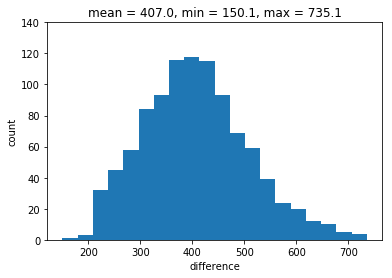

In [52]:
error_images, error_vals, error_means = src.error_distribution(truth,predictions)

Plot and save examples

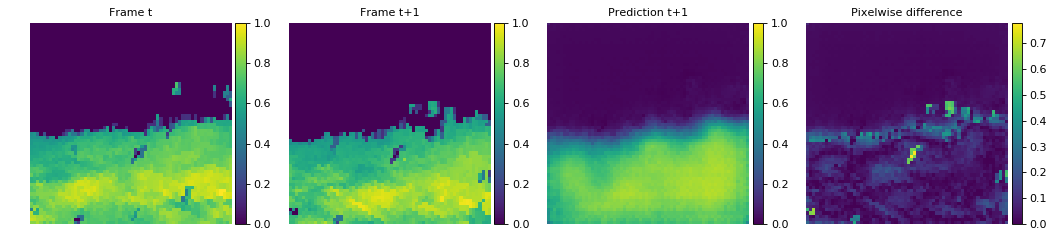

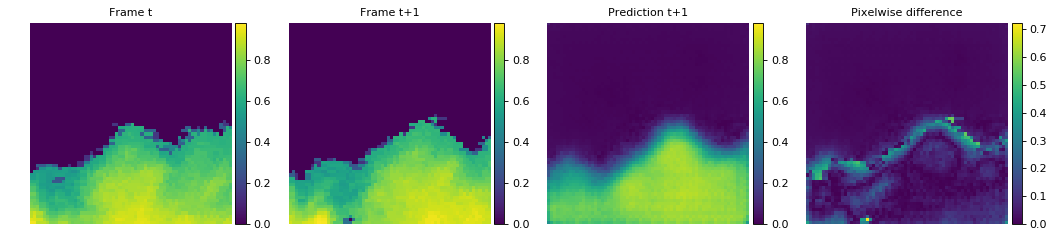

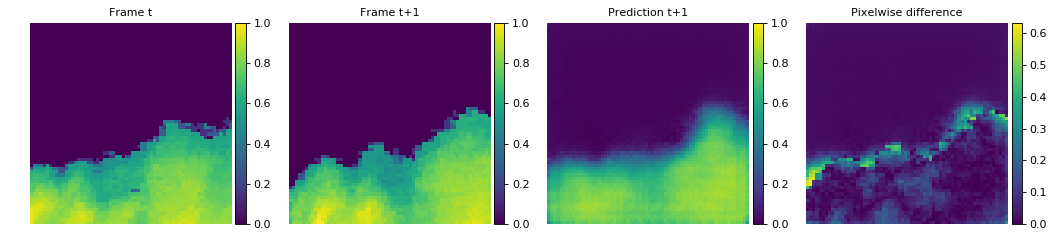

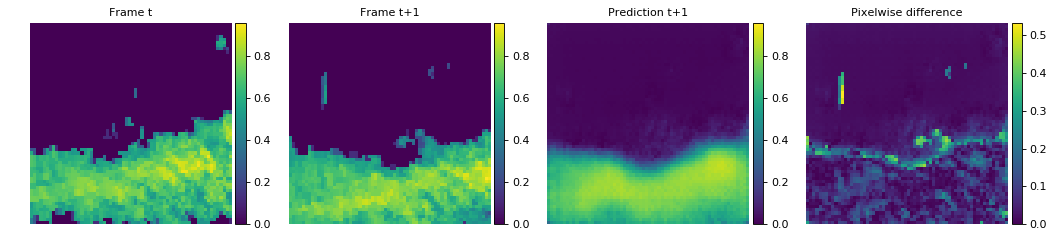

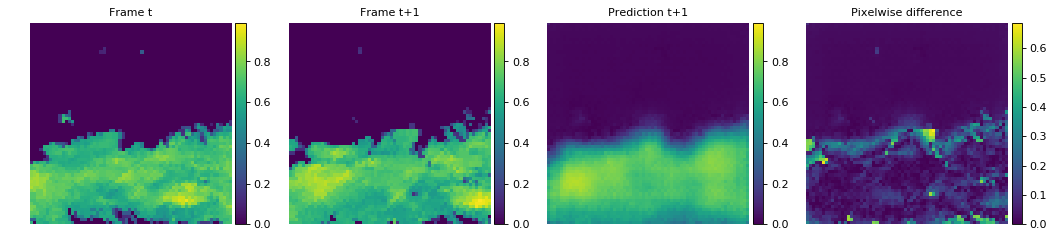

In [53]:
src.result_plotter(args[:5], (unet_test[:,:,:,0], truth[:,:,:,0], predictions[:,:,:,0], error_images[:,:,:,0]))